# Wildfires WISE Fire Spread Model — Uncertainty Quantification (UQ) Notebook 
**Project:** Destination Earth (DestinE) 
**Author:** Joonas Kolstela - Finnish Meteorological Institute 
**Date:** 30-9-2025 
This notebook contains the Uncertainty Quantification (UQ) for the WISE application in Destination Earth Climate Digital Twin. The UQ is based on the following: 
- Two ignition locations in Finland 
    - Kalajoki (lat:64.007044, lon: 24.152986) 
    - Koli (lat: 63.050609, lon: 29.889436) 
- Fire spread was calculated daily for the fire relevant months of Finland (May - August) for the years 1990 - 1994. 
- DestinE runs are based on the o005 experiment run, while ERA5 data is the ERA5-reanalysis dataset. 
- Same climate variables were used from both climate data sources. Used variables were:
    - Hourly temperature
    - Hourly relative humidity
    - Hourly wind speed
    - Hourly wind direction
    - Daily precipitation
 Auxiliary files used in both runs were identical. Variables consists of:
    - Digital elevation model (16x16 m)
    - Fuel classification map (16x16 m) 
- UQ is based on a comparison between: 
    - times each grid cell (16x16 m spatial resolution) burned in the area 
    - median and maximum fire intensity in each grid cell 
    - median and maximum flame length in each grid cell this is the current notebook.

# 1. Package and data loading

This notebook compares two sets of WISE application runs using climate data from Destination Earth simulations and ERA5 reanalysis data for two locations in Finland
across May–August for years 1990–1994. We load daily GeoTIFFs,
aggregate per-cell metrics, and then compute differences between the runs.


In [ ]:
# package and data loading

from pathlib import Path
from datetime import datetime
import re
import numpy as np
import rasterio
import rasterio.mask
import matplotlib.pyplot as plt
from matplotlib import pyplot

RUN_ROOTS = {
    "DestinE": Path("D:/wise_development/wise_uq/runs/results/climate_dt"),
    "ERA5": Path("D:/wise_development/wise_uq/runs/results/era5")
}

# WISE scenario ignition point locations
LOCATIONS = {
    "location_1": {"name": "Kalajoki", "lat": 64.007044, "lon": 24.152986},
    "location_2": {"name": "Koli",     "lat": 63.050609, "lon": 29.889436},
}

# WISE scenario years and months
YEARS  = list(range(1990, 1995))
MONTHS = [5, 6, 7, 8]

# WISE scenario output variables
VARS = {
    "burn": "burn_grid",
    "fi":   "max_intensity",
    "fl":   "max_flame_length",
}

# Selecting WISE scenario output directories (names vary between DestinE and ERA5 runs)
def _parse_dir_date(name: str) -> datetime:

    m = re.search(r'(\d{4}-\d{2}-\d{2})$', name)
    if m:
        return datetime.strptime(m.group(1), "%Y-%m-%d")

    m = re.search(r'(\d{8})$', name)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d")

    m = re.search(r'(\d{8})', name)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d")
    
    m = re.search(r'(\d{4}-\d{2}-\d{2})', name)
    if m:
        return datetime.strptime(m.group(1), "%Y-%m-%d")
    raise ValueError(f"Cannot parse date from directory name: '{name}'")

# Selecting variables from WISE scenario output directories
def _iter_daily_files(run_root: Path, location_key: str, var_key: str):

    loc_dir = run_root / location_key
    if not loc_dir.exists():
        return
    
    for day_dir in sorted((p for p in loc_dir.iterdir() if p.is_dir()), key=lambda p: p.name):
        try:
            dt = _parse_dir_date(day_dir.name)
        except ValueError:
    
            continue
        if dt.year in YEARS and dt.month in MONTHS:
            tif = day_dir / f"{VARS[var_key]}.tif"
            if tif.exists():
                yield dt, tif


def _read_masked(tif: Path):
    with rasterio.open(tif) as ds:
        arr = ds.read(1, masked=True).astype("float32")
        profile = ds.profile
    return arr, profile

# collects all run outputs and stacks them
def _stack_arrays(file_list):

    arrays = []
    profile = None
    for _, tif in file_list:
        a, prof = _read_masked(tif)
        arrays.append(a.filled(np.nan))
        if profile is None:
            profile = prof
    if not arrays:
        return None, None
    stack = np.stack(arrays, axis=0).astype("float32")  # (T,H,W)
    return stack, profile

# computes different metrics (e.g. times burned and fire intensity and flame lenghth information from outputs)
def compute_location_metrics_for_run(run_root: Path, location_key: str):

    # Burn stack
    burn_files = list(_iter_daily_files(run_root, location_key, "burn"))
    burn_stack, profile = _stack_arrays(burn_files)

    # Intensity stack
    fi_files = list(_iter_daily_files(run_root, location_key, "fi"))
    fi_stack, _ = _stack_arrays(fi_files)

    # Flame length stack
    fl_files = list(_iter_daily_files(run_root, location_key, "fl"))
    fl_stack, _ = _stack_arrays(fl_files)

    if burn_stack is None:
        return {
            "times_burned": None,
            "fi_median": None, "fi_max": None,
            "fl_median": None, "fl_max": None,
            "profile": None, "days": 0,
        }

    
    times_burned = np.sum(burn_stack > 0, axis=0).astype("int16")

    
    if fi_stack is not None:
        fi_median = np.nanmedian(fi_stack, axis=0).astype("float32")
        fi_max    = np.nanmax(fi_stack,    axis=0).astype("float32")
    else:
        fi_median = fi_max = None

    
    if fl_stack is not None:
        fl_median = np.nanmedian(fl_stack, axis=0).astype("float32")
        fl_max    = np.nanmax(fl_stack,    axis=0).astype("float32")
    else:
        fl_median = fl_max = None

    return {
        "times_burned": times_burned,
        "fi_median": fi_median, "fi_max": fi_max,
        "fl_median": fl_median, "fl_max": fl_max,
        "profile": profile,
        "days": burn_stack.shape[0],
    }


metrics = {loc: {} for loc in LOCATIONS}
for run_name, run_root in RUN_ROOTS.items():
    for loc_key in LOCATIONS:
        print(f"Loading {run_name} — {loc_key} ...")
        metrics[loc_key][run_name] = compute_location_metrics_for_run(run_root, loc_key)
print("Done.")


Loading DestinE — location_1 ...


c:\Users\kolstela\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1243: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\kolstela\AppData\Local\Temp\ipykernel_26628\3446987763.py:150: RuntimeWarning: All-NaN slice encountered
  fi_max    = np.nanmax(fi_stack,    axis=0).astype("float32")
C:\Users\kolstela\AppData\Local\Temp\ipykernel_26628\3446987763.py:157: RuntimeWarning: All-NaN slice encountered
  fl_max    = np.nanmax(fl_stack,    axis=0).astype("float32")


Loading DestinE — location_2 ...
Loading ERA5 — location_1 ...
Loading ERA5 — location_2 ...
Done.


# 2. Metric calculation & DestinE−ERA5 differences

For each location, we compute:
- **times_burned** across all days (count of daily burns per cell)
- **fi_median / fi_max**: median and max fire intensity per cell across days
- **fl_median / fl_max**: median and max flame length per cell across days

After this we calculate the difference in each metric (DestinE − ERA5).


In [ ]:
# 2. Calculating metrics and differences (DestinE − ERA5)


def diff_arrays(a, b):
    if a is None or b is None:
        return None

    if a.shape != b.shape:
        raise ValueError(f"Array shape mismatch: {a.shape} vs {b.shape}")
    out = (a.astype("float32") - b.astype("float32"))

    nan_mask = np.isnan(a) | np.isnan(b)
    out[nan_mask] = np.nan
    return out

diffs = {}
for loc_key in LOCATIONS:
    dest = metrics[loc_key]["DestinE"]
    era5 = metrics[loc_key]["ERA5"]
    diffs[loc_key] = {
        "times_burned": diff_arrays(dest["times_burned"], era5["times_burned"]),
        "fi_median":    diff_arrays(dest["fi_median"],    era5["fi_median"]),
        "fi_max":       diff_arrays(dest["fi_max"],       era5["fi_max"]),
        "fl_median":    diff_arrays(dest["fl_median"],    era5["fl_median"]),
        "fl_max":       diff_arrays(dest["fl_max"],       era5["fl_max"]),
        "profile":      dest["profile"] or era5["profile"],
    }

print("Differences computed.")


Differences computed.


# 3. Plotting

We plot, for each location:
- DestinE vs ERA5 maps (times burned, FI median & max, FL median & max)
- The corresponding **difference** maps (DestinE − ERA5)

> Note: Default Matplotlib styling is used (per project constraints). One figure per plot.


Plotting base rasters for Kalajoki …


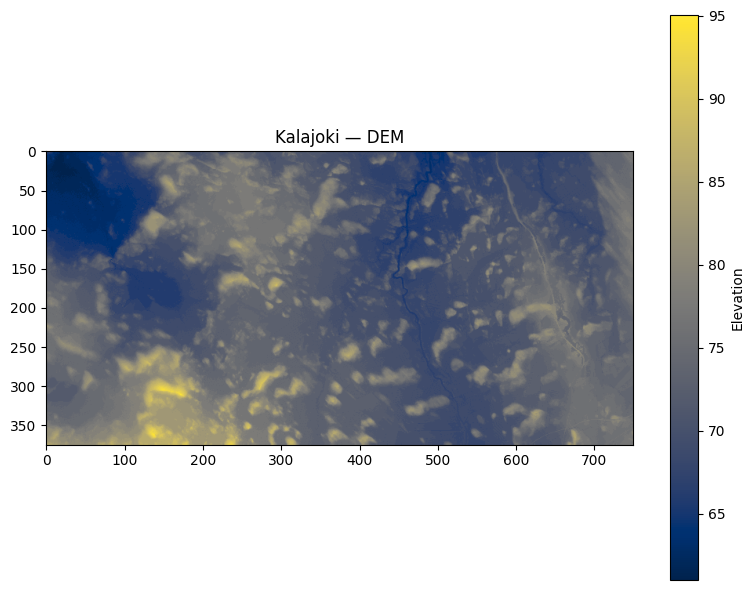

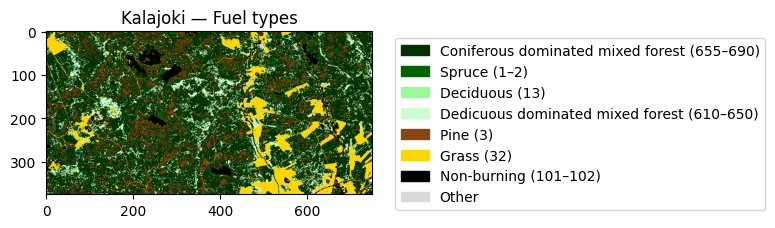

Plotting base rasters for Koli …


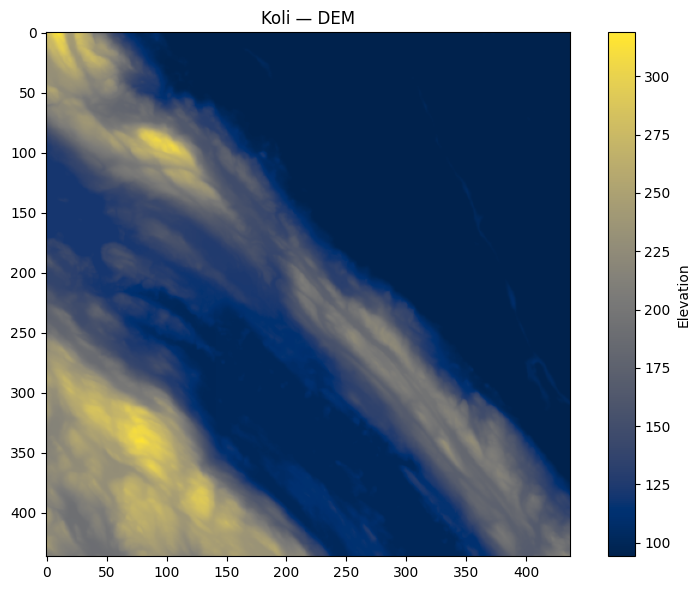

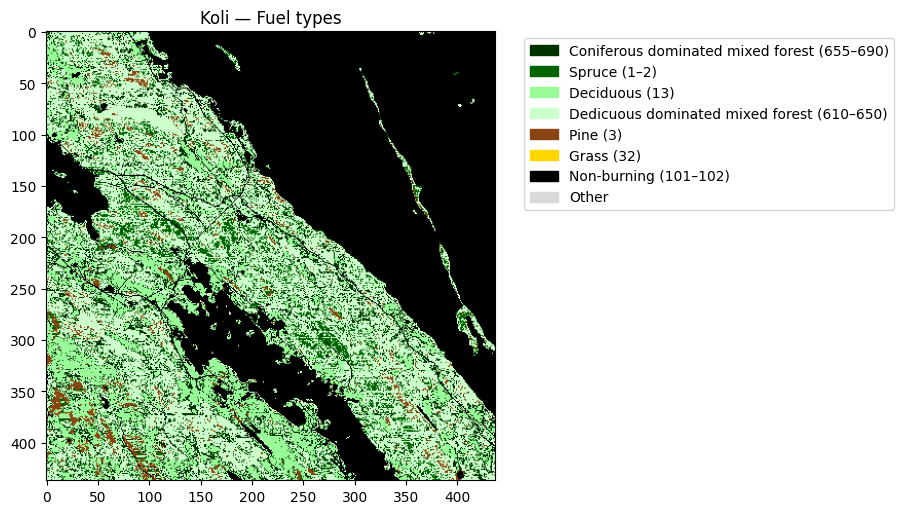

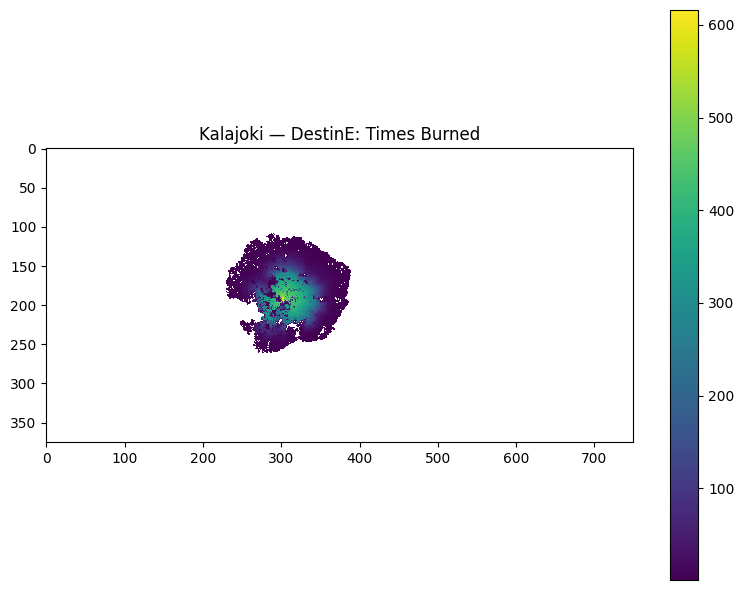

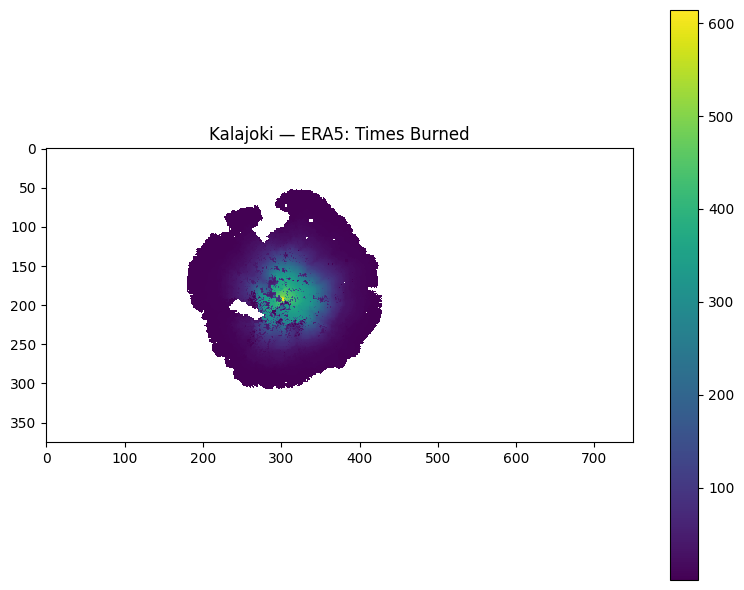

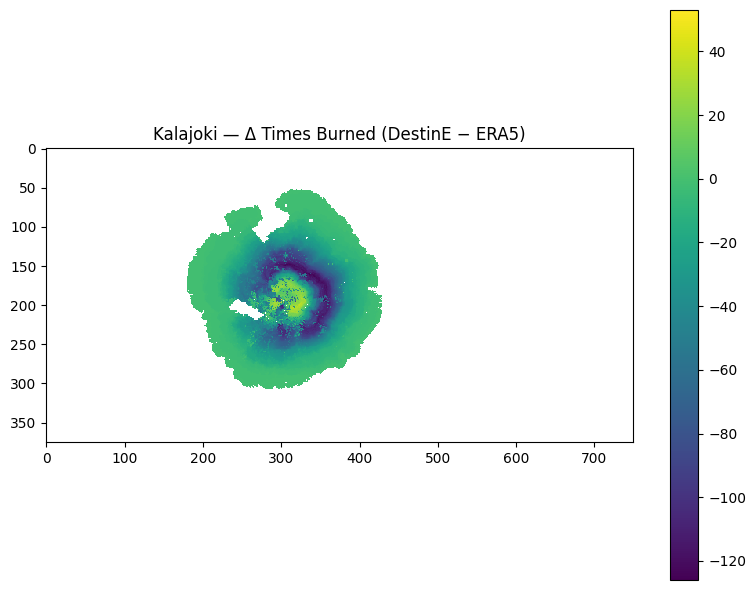

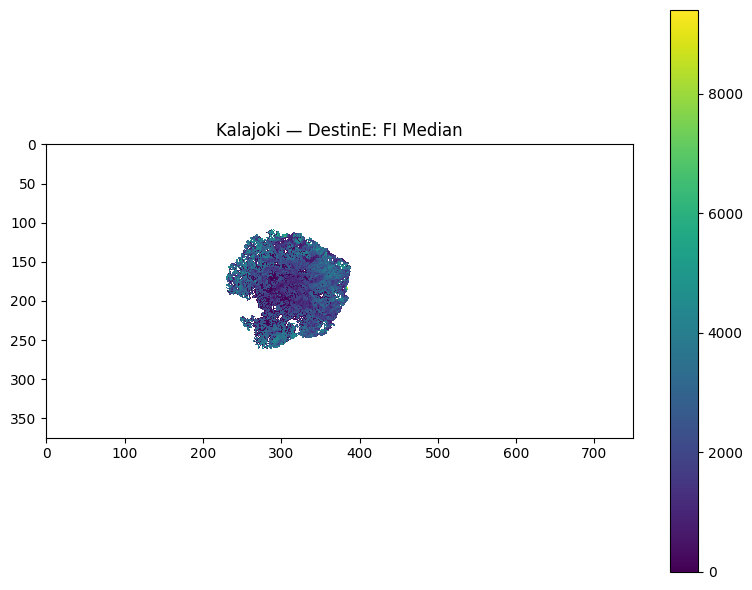

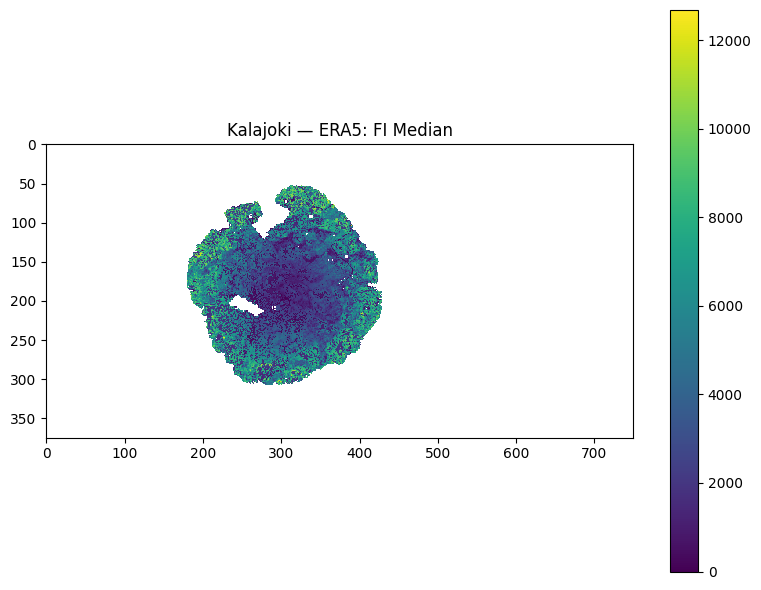

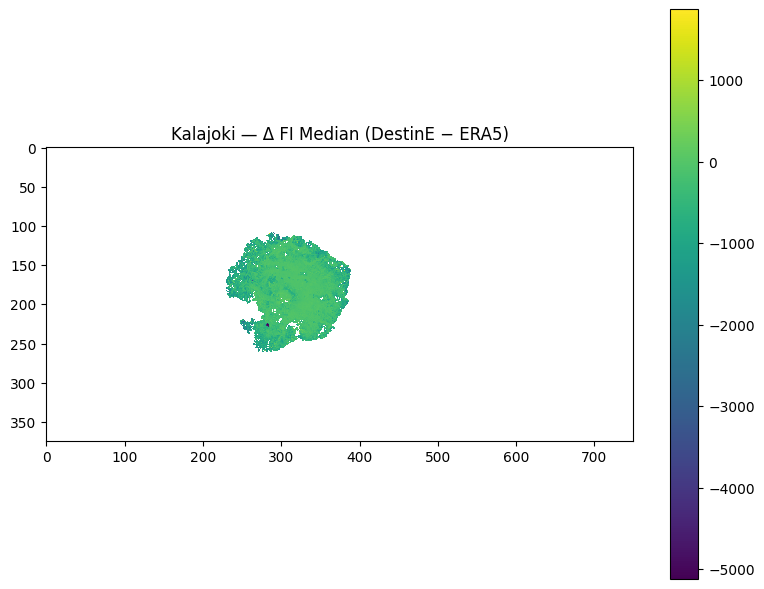

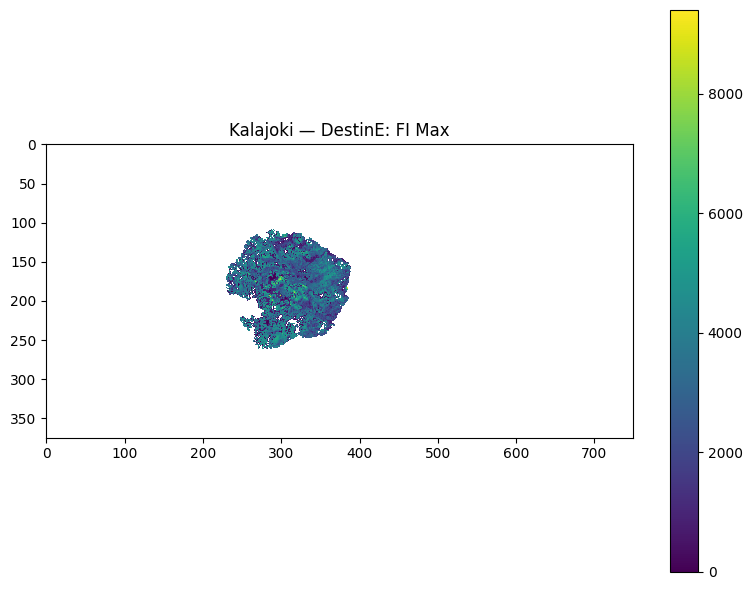

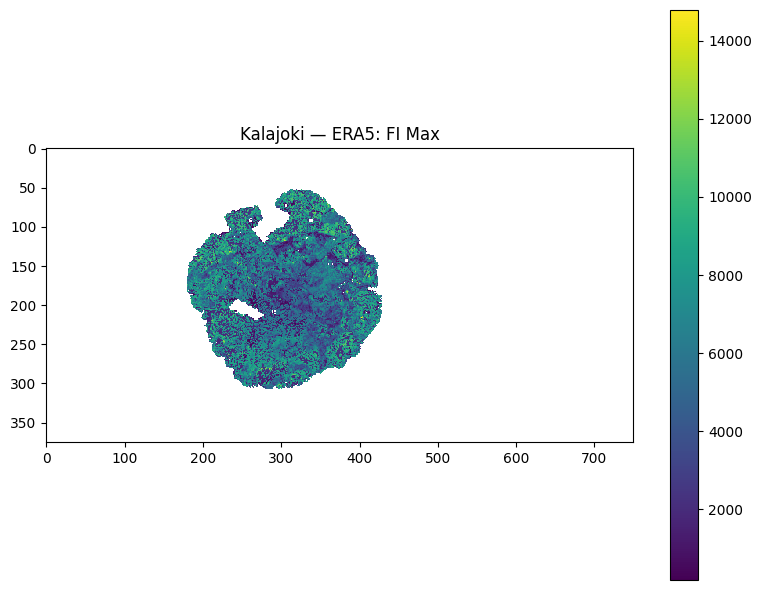

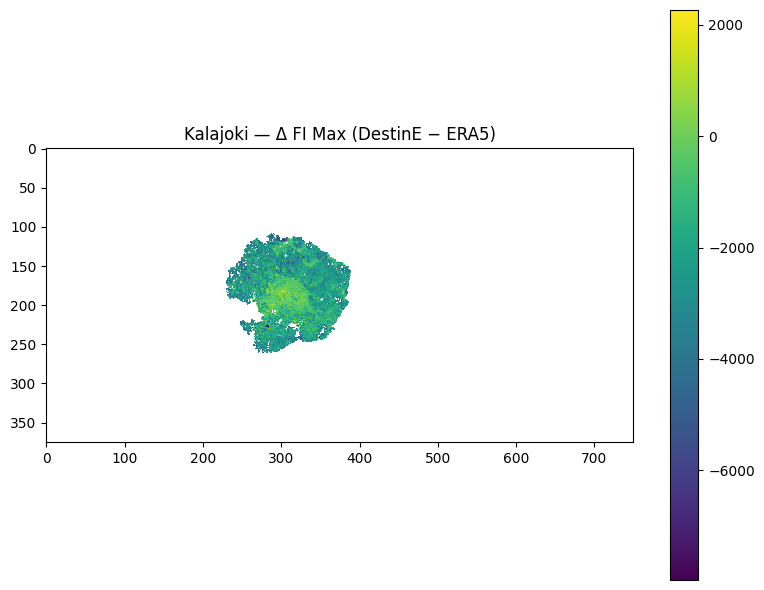

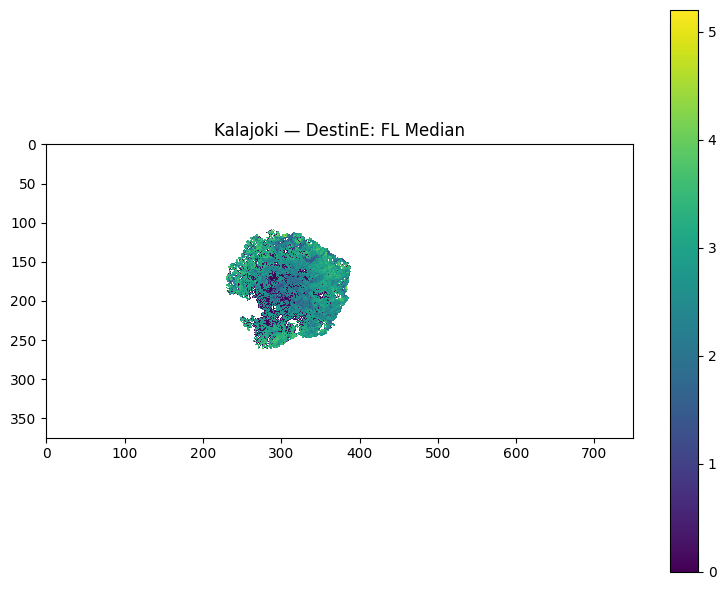

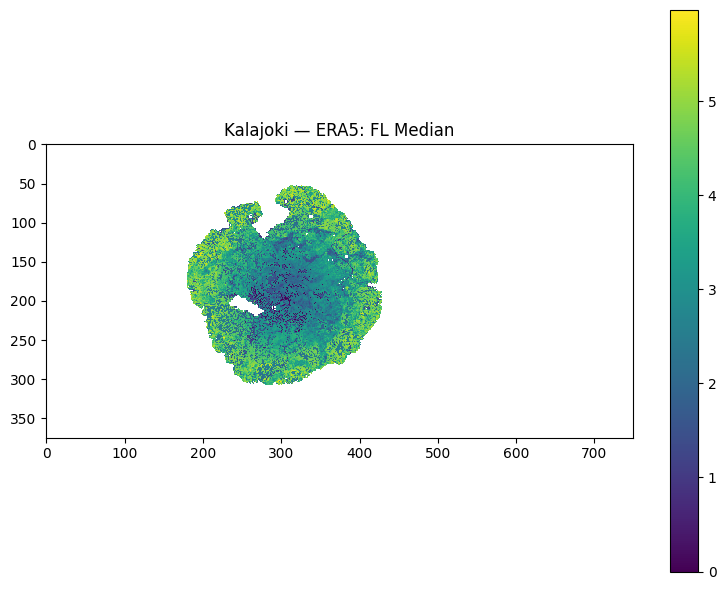

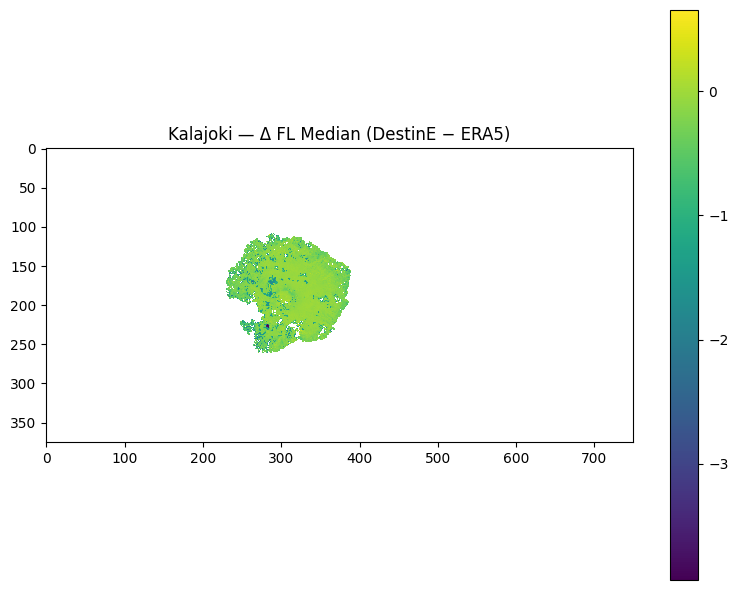

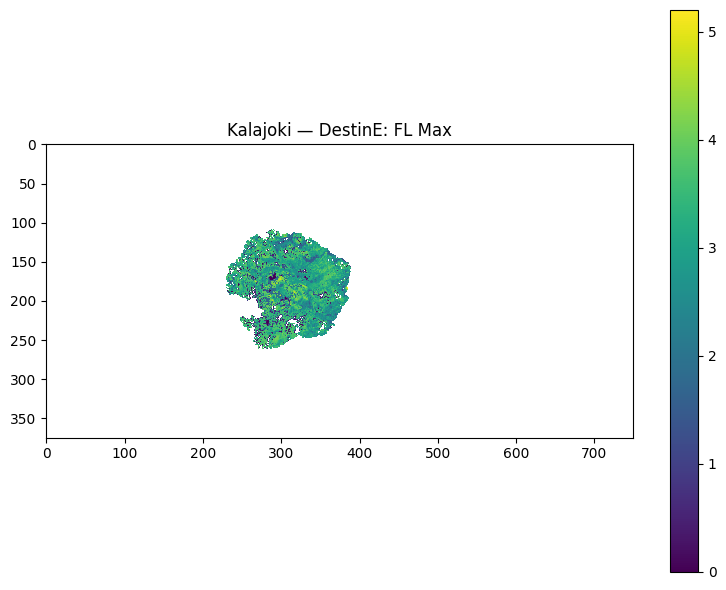

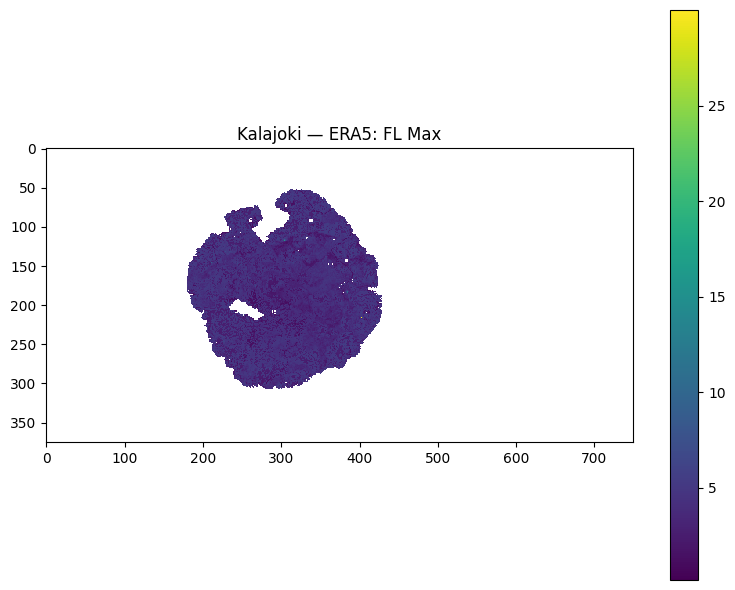

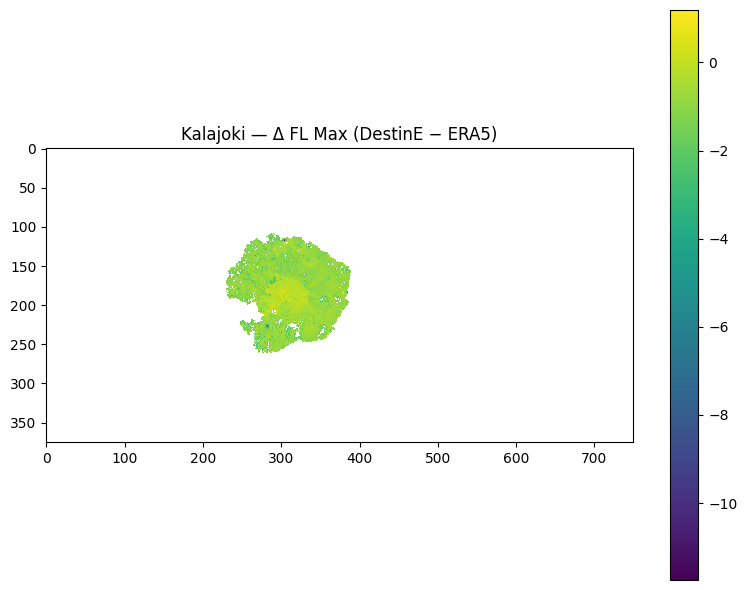

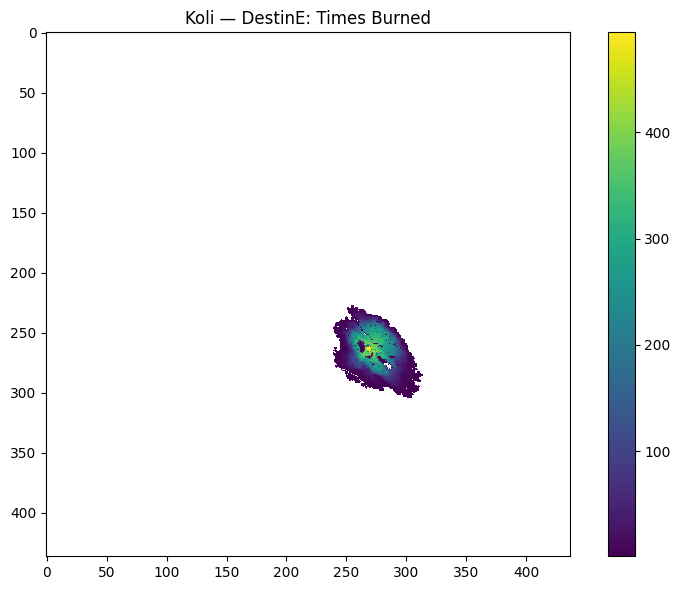

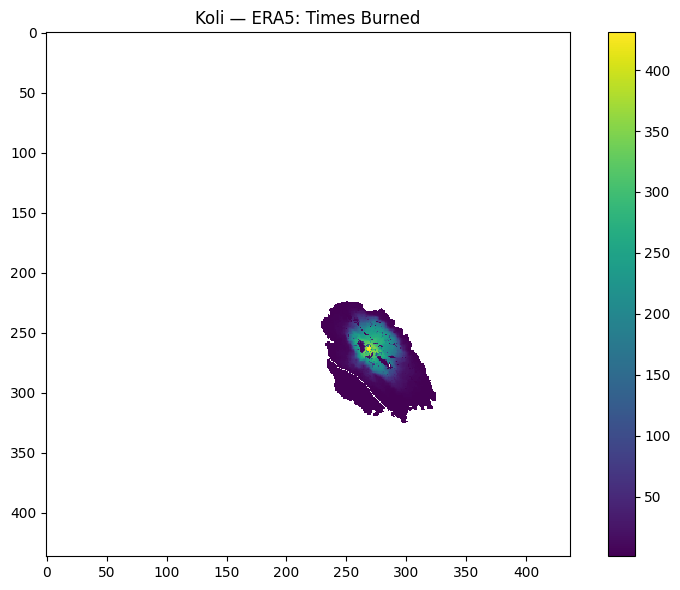

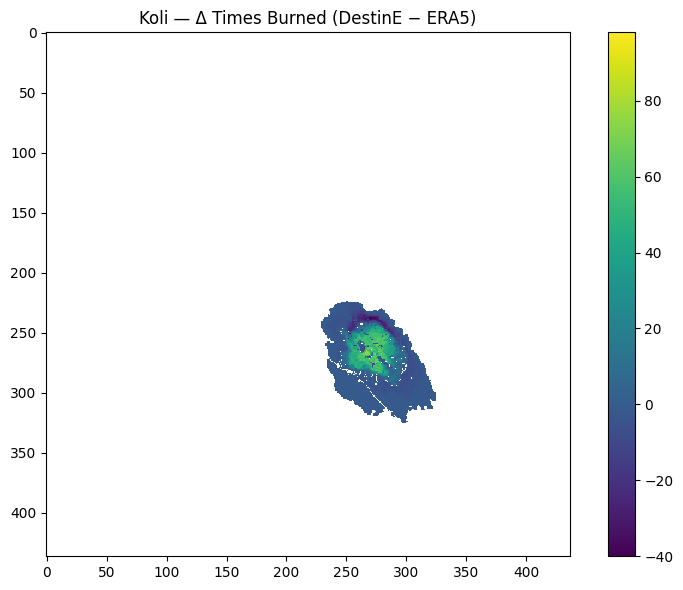

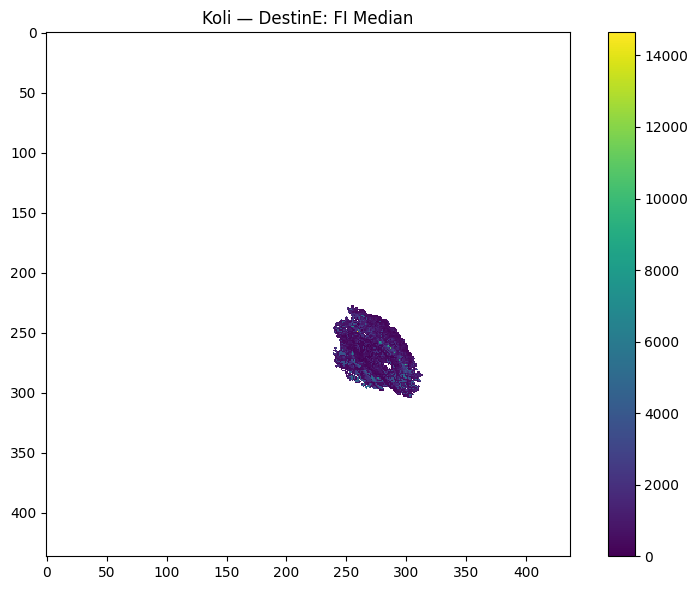

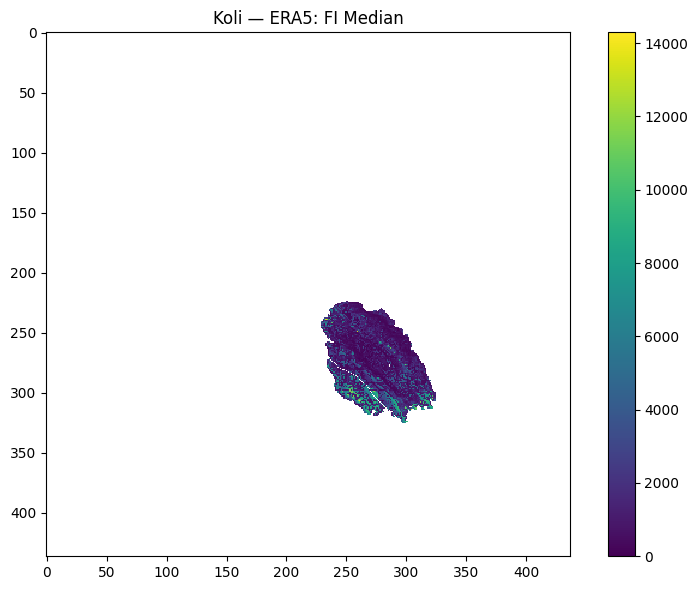

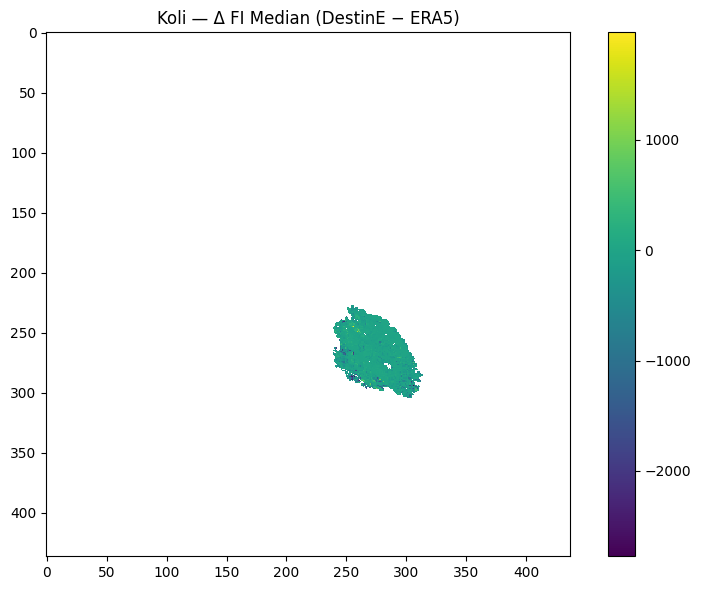

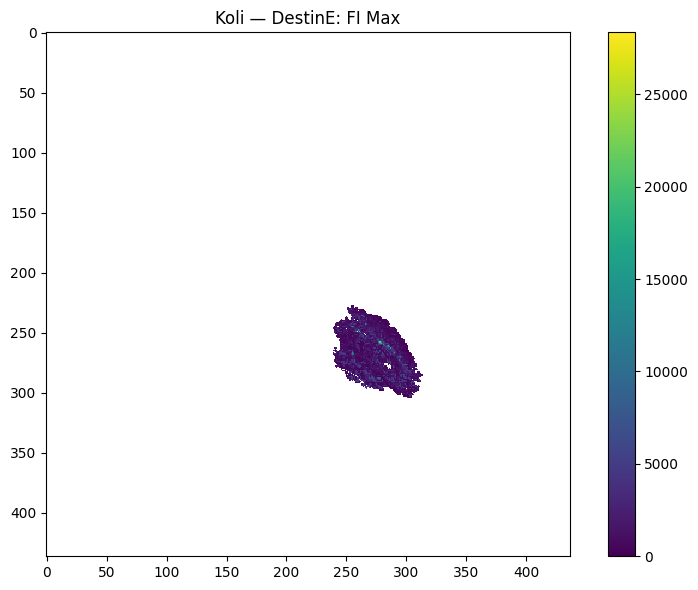

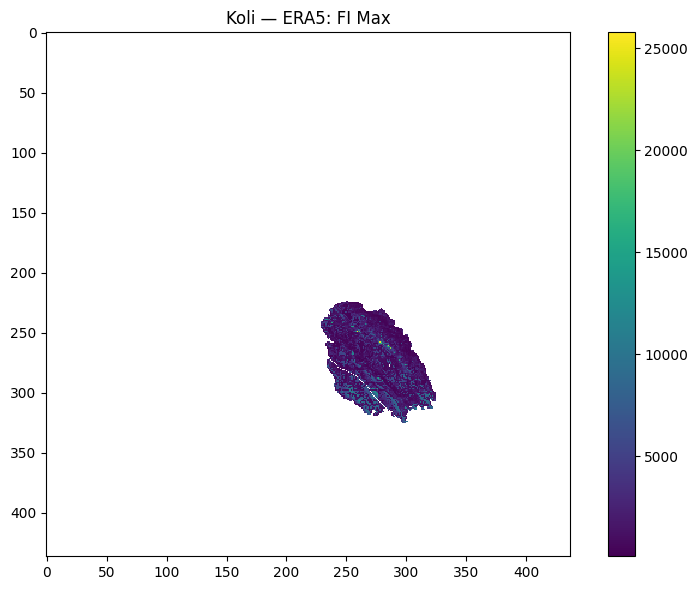

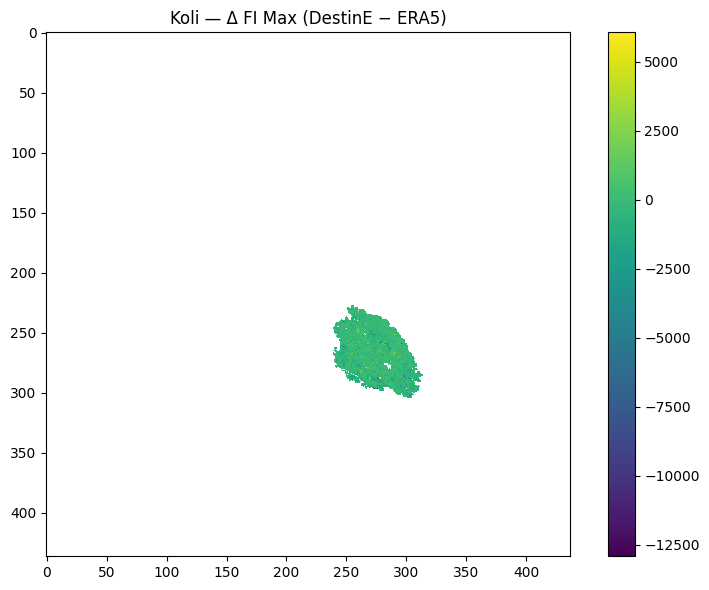

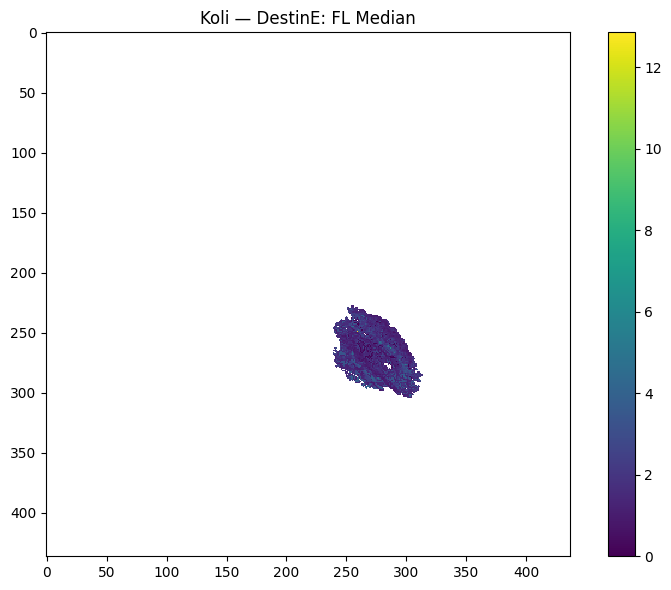

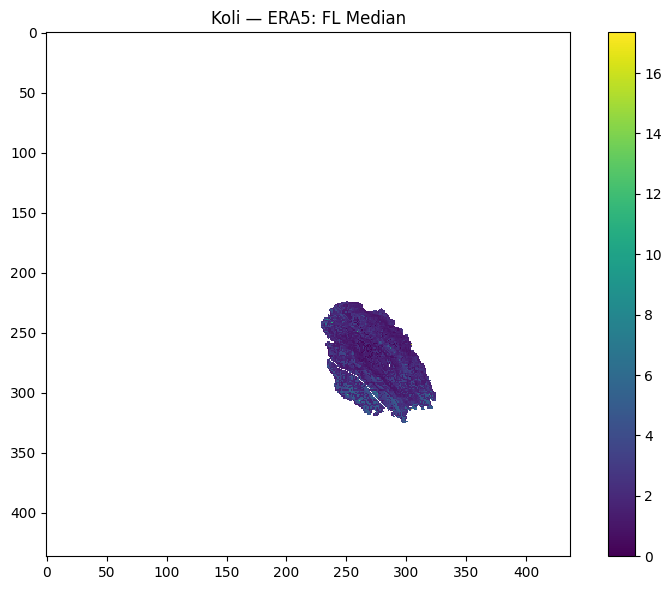

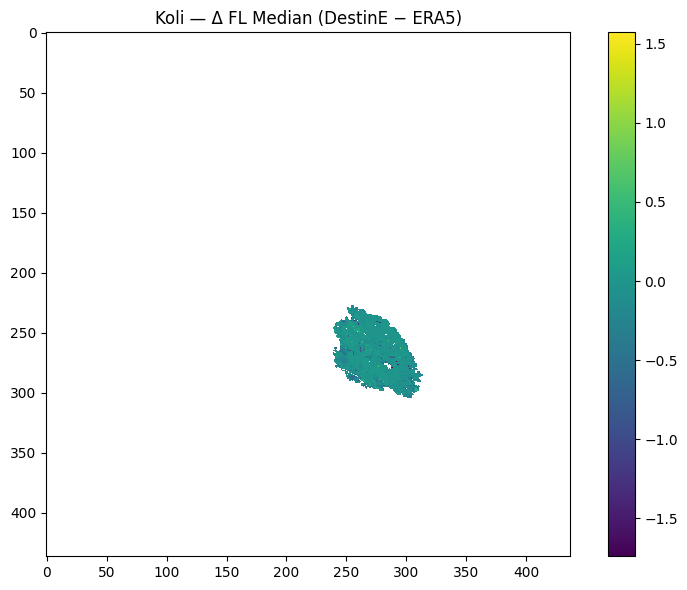

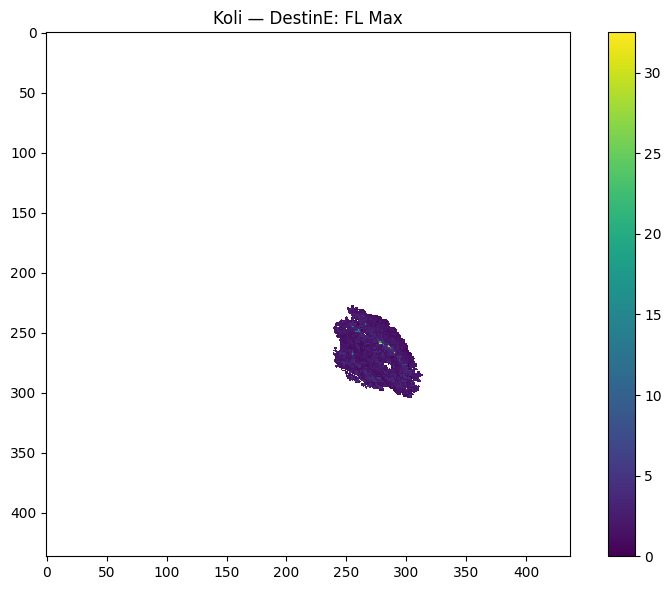

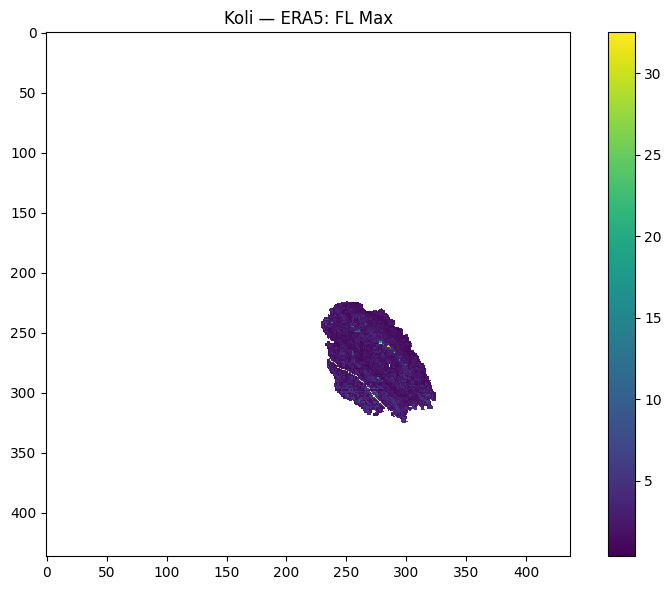

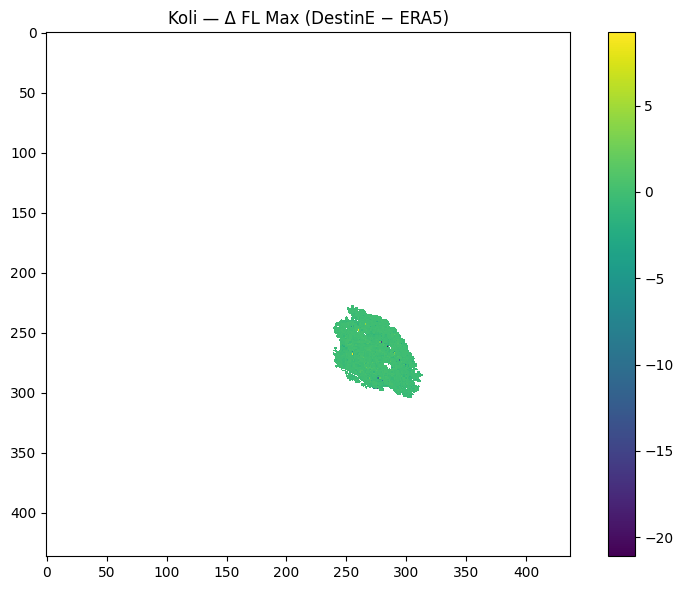

In [ ]:

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches


AUX_ROOT = Path("D:/wise_development/wise_uq/runs/aux_data")
FUEL_DEM_PATHS = {
    "Kalajoki": {
        "dem":  AUX_ROOT / "location_1" / "dem.asc",
        "fuel": AUX_ROOT / "location_1" / "fuel.asc",
    },
    "Koli": {
        "dem":  AUX_ROOT / "location_2" / "dem.asc",
        "fuel": AUX_ROOT / "location_2" / "fuel.asc",
    },
}

def _reclassify_fuel(arr: np.ndarray) -> np.ndarray:
    """
    Reclassify fuel integer codes into plotting classes:

      0 = Other
      1 = Dark green       (1–2)
      2 = Brown            (3)
      3 = Light green      (13)
      4 = Lighter green    (610–650)  <-- lighter than class 3
      5 = Yellow           (32)
      6 = Black            (101–102)
      7 = Very dark green  (655–690)  <-- darker than class 1
    """
    out = np.zeros(arr.shape, dtype=np.uint8)
    with np.errstate(invalid="ignore"):
        out[(arr >= 1) & (arr <= 2)] = 1
        out[arr == 3] = 2
        out[arr == 13] = 3
        out[(arr >= 610) & (arr <= 650)] = 4
        out[arr == 32] = 5
        out[(arr >= 101) & (arr <= 102)] = 6
        out[(arr >= 655) & (arr <= 690)] = 7
    return out

def plot_dem_and_fuel_from_paths(dem_path: Path, fuel_path: Path, title_prefix: str):

    if not dem_path.exists():
        print(f"[skip] DEM not found: {dem_path}")
        return
    if not fuel_path.exists():
        print(f"[skip] Fuel not found: {fuel_path}")
        return


    with rasterio.open(dem_path) as ds:
        dem = ds.read(1, masked=True).astype("float32")
    plt.figure(figsize=(8, 6))
    plt.imshow(dem, origin="upper", cmap="cividis")
    plt.title(f"{title_prefix} — DEM")
    plt.colorbar(label="Elevation")
    plt.tight_layout()
    plt.show()


    with rasterio.open(fuel_path) as ds:
        fuel = ds.read(1, masked=True).astype("float32")
    fuel_arr = fuel.filled(np.nan)

    cats = _reclassify_fuel(fuel_arr)


    cmap = ListedColormap([
        "#d9d9d9",  # 0 Other (light grey)
        "#006400",  # 1 Dark green (1–2)
        "#8b4513",  # 2 Brown (3)
        "#98fb98",  # 3 Light green (13)
        "#ccffcc",  # 4 Lighter green (610–650) -- lighter than 13
        "#ffd700",  # 5 Yellow (32)
        "#000000",  # 6 Black (101–102)
        "#003200",  # 7 Very dark green (655–690) -- darker than class 1
    ])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
    norm = BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(8, 6))
    plt.imshow(cats, origin="upper", cmap=cmap, norm=norm)
    plt.title(f"{title_prefix} — Fuel types")

    legend_patches = [
        mpatches.Patch(color=cmap.colors[7], label="Coniferous dominated mixed forest (655–690)"),
        mpatches.Patch(color=cmap.colors[1], label="Spruce (1–2)"),
        mpatches.Patch(color=cmap.colors[3], label="Deciduous (13)"),
        mpatches.Patch(color=cmap.colors[4], label="Dedicuous dominated mixed forest (610–650)"),
        mpatches.Patch(color=cmap.colors[2], label="Pine (3)"),
        mpatches.Patch(color=cmap.colors[5], label="Grass (32)"),
        mpatches.Patch(color=cmap.colors[6], label="Non-burning (101–102)"),
        mpatches.Patch(color=cmap.colors[0], label="Other"),
    ]
    plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


for area_name, paths in FUEL_DEM_PATHS.items():
    print(f"Plotting base rasters for {area_name} …")
    plot_dem_and_fuel_from_paths(paths["dem"], paths["fuel"], area_name)




# 3. Plotting helper utilities

def _imshow(arr, title, *, mask_zero=False, cmap="viridis", vmin=None, vmax=None):
    """
    Show a 2D array. If mask_zero=True, pixels that are exactly 0 (and NaNs)
    are masked and rendered fully transparent.
    """
    if arr is None:
        print(f"[skip] {title} — no data")
        return


    A = arr.astype("float32", copy=False)
    if mask_zero:
        mask = np.isnan(A) | (A == 0)
        A = np.ma.array(A, mask=mask)
        cm = plt.get_cmap(cmap).copy()
        cm.set_bad(alpha=0.0)   
    else:
        cm = plt.get_cmap(cmap)

    plt.figure(figsize=(8, 6))
    im = plt.imshow(A, origin="upper", cmap=cm, vmin=vmin, vmax=vmax, interpolation="nearest")
    plt.title(title)
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()


def plot_location(loc_key: str):
    loc_name = LOCATIONS[loc_key]["name"]
    d = metrics[loc_key]["DestinE"]
    e = metrics[loc_key]["ERA5"]
    x = diffs[loc_key]


    _imshow(d["times_burned"], f"{loc_name} — DestinE: Times Burned",
            mask_zero=True, cmap="viridis")
    _imshow(e["times_burned"], f"{loc_name} — ERA5: Times Burned",
            mask_zero=True, cmap="viridis")
    _imshow(x["times_burned"], f"{loc_name} — Δ Times Burned (DestinE − ERA5)",
            mask_zero=True, cmap="viridis")


    _imshow(d["fi_median"], f"{loc_name} — DestinE: FI Median",
            mask_zero=False, cmap="viridis")
    _imshow(e["fi_median"], f"{loc_name} — ERA5: FI Median",
            mask_zero=False, cmap="viridis")
    _imshow(x["fi_median"], f"{loc_name} — Δ FI Median (DestinE − ERA5)",
            mask_zero=True, cmap="viridis")

    _imshow(d["fi_max"], f"{loc_name} — DestinE: FI Max",
            mask_zero=False, cmap="viridis")
    _imshow(e["fi_max"], f"{loc_name} — ERA5: FI Max",
            mask_zero=False, cmap="viridis")
    _imshow(x["fi_max"], f"{loc_name} — Δ FI Max (DestinE − ERA5)",
            mask_zero=True, cmap="viridis")


    _imshow(d["fl_median"], f"{loc_name} — DestinE: FL Median",
            mask_zero=False, cmap="viridis")
    _imshow(e["fl_median"], f"{loc_name} — ERA5: FL Median",
            mask_zero=False, cmap="viridis")
    _imshow(x["fl_median"], f"{loc_name} — Δ FL Median (DestinE − ERA5)",
            mask_zero=True, cmap="viridis")

    _imshow(d["fl_max"], f"{loc_name} — DestinE: FL Max",
            mask_zero=False, cmap="viridis")
    _imshow(e["fl_max"], f"{loc_name} — ERA5: FL Max",
            mask_zero=False, cmap="viridis")
    _imshow(x["fl_max"], f"{loc_name} — Δ FL Max (DestinE − ERA5)",
            mask_zero=True, cmap="viridis")



plot_location("location_1")
plot_location("location_2")


# 4. Aggregate metrics

We summarize a few headline statistics per location and run:
- **Total burned area** (cells that burned ≥1 time × cell area)
- **Mean times burned** over burned cells
- **Mean FI/FL (median & max)** over burned cells
- Simple **DestinE − ERA5** deltas for each metric


In [ ]:
# 4. Calculating aggregate metrics

def cell_area_m2(profile):

    from affine import Affine
    tr: Affine = profile["transform"]
    return abs(tr.a * tr.e)

def summarize_metrics(arr_burn_times, fi_med, fi_max, fl_med, fl_max, profile):
    if arr_burn_times is None or profile is None:
        return {"burned_area_m2": 0.0, "mean_times_burned": np.nan,
                "fi_med_mean": np.nan, "fi_max_mean": np.nan,
                "fl_med_mean": np.nan, "fl_max_mean": np.nan}
    area = cell_area_m2(profile)
    burned_mask = (arr_burn_times > 0)
    burned_cells = np.sum(burned_mask)
    burned_area = burned_cells * area
    mean_times = np.mean(arr_burn_times[burned_mask]) if burned_cells else np.nan

    def masked_mean(x):
        if x is None or burned_cells == 0:
            return np.nan
        v = np.where(burned_mask, x, np.nan)
        return np.nanmean(v)

    return {
        "burned_area_m2": float(burned_area),
        "mean_times_burned": float(mean_times) if not np.isnan(mean_times) else np.nan,
        "fi_med_mean": float(masked_mean(fi_med)),
        "fi_max_mean": float(masked_mean(fi_max)),
        "fl_med_mean": float(masked_mean(fl_med)),
        "fl_max_mean": float(masked_mean(fl_max)),
    }

summary = {}
for loc_key in LOCATIONS:
    summary[loc_key] = {}
    for run_name in RUN_ROOTS:
        m = metrics[loc_key][run_name]
        summary[loc_key][run_name] = summarize_metrics(
            m["times_burned"], m["fi_median"], m["fi_max"], m["fl_median"], m["fl_max"], m["profile"]
        )


import pandas as pd
rows = []
for loc_key, runs in summary.items():
    for run_name, s in runs.items():
        rows.append({
            "location": LOCATIONS[loc_key]["name"],
            "run": run_name,
            "burned_area_km2": s["burned_area_m2"] / 1e6,
            "mean_times_burned": s["mean_times_burned"],
            "FI_median_mean": s["fi_med_mean"],
            "FI_max_mean": s["fi_max_mean"],
            "FL_median_mean": s["fl_med_mean"],
            "FL_max_mean": s["fl_max_mean"],
        })
df_summary = pd.DataFrame(rows)
display(df_summary.round(3))


delta_rows = []
for loc_key in LOCATIONS:
    d = summary[loc_key]["DestinE"]
    e = summary[loc_key]["ERA5"]
    delta_rows.append({
        "location": LOCATIONS[loc_key]["name"],
        "Δ burned_area_km2": (d["burned_area_m2"] - e["burned_area_m2"]) / 1e6,
        "Δ mean_times_burned": d["mean_times_burned"] - e["mean_times_burned"],
        "Δ FI_median_mean": d["fi_med_mean"] - e["fi_med_mean"],
        "Δ FI_max_mean": d["fi_max_mean"] - e["fi_max_mean"],
        "Δ FL_median_mean": d["fl_med_mean"] - e["fl_med_mean"],
        "Δ FL_max_mean": d["fl_max_mean"] - e["fl_max_mean"],
    })
df_deltas = pd.DataFrame(delta_rows)
display(df_deltas.round(3))


,location,run,burned_area_km2,mean_times_burned,FI_median_mean,FI_max_mean,FL_median_mean,FL_max_mean
0,Kalajoki,DestinE,4.092,85.095,2191.001,3009.220,2.412,2.879
1,Kalajoki,ERA5,11.202,55.740,4129.166,5511.647,3.335,3.904
2,Koli,DestinE,0.908,102.243,1170.940,1848.041,1.770,2.264
3,Koli,ERA5,1.569,52.324,1867.778,2457.574,2.162,2.567


,location,Δ burned_area_km2,Δ mean_times_burned,Δ FI_median_mean,Δ FI_max_mean,Δ FL_median_mean,Δ FL_max_mean
0,Kalajoki,-7.110,29.355,-1938.165,-2502.427,-0.923,-1.025
1,Koli,-0.661,49.919,-696.839,-609.533,-0.392,-0.303


# 5. Discussion

As the WISE model version (Version 1.0.6-beta released on 2023-03-01) auxiliary data (topography and fuel classification), and fire propagation start and end times are identical, differences in results are due to differences in the weather data used.

In most metrics, runs using ERA5 data produce more intensive and faster spreading fires. This is most likely caused by overall wetter conditions in the DestinE model runs, limiting the amount of fuel,intensity and spread rates of fires. Another noticable difference in the Kalajoki scenarios is that the pine fuel class rarely burns when modelled using the DestinE o005 experiment data, but does burn when using ERA5 data. It could also be due to an unknown error in the WISE model, as the C-3 Pine fuel class should burn in Finnish summer weather conditions.

The more intensive fires also allow for canopy fires in the ERA5 based runs, as seen in the maximum flame length (although rarely). The DestinE based runs have a maximum flame length of ~5 m, while ERA5 based ones reach heights of over 25 meters suggesting that the fire reaches the canopy layer during certain fires and locations.

In the Koli region, the differences between DestinE and ERA5 based runs are not as pronounced, but are mostly higher in the ERA5 based runs.


- **Coverage / data quality:** note any missing days, nodata areas, or misalignments.
- **Systematic differences:** do DestinE results show higher/lower FI/FL or burned frequency?
- **Spatial patterns:** where do the differences cluster (topography, fuels, exposure)?
- **Sensitivity:** which metric (times burned, FI median/max, FL median/max) exhibits the largest spread?
- **Next steps:** quantify uncertainty sources (weather vs fuels vs model), add significance testing, refine masking, etc.
